## setup

In [1]:
topology = 'A'
omission = 'omitExMet'

In [2]:
SEED = 1

from scipy.stats import f_oneway
from scipy.stats import kruskal

import pandas as pd
import numpy as np
np.random.seed(SEED)
import tellurium as te

import random
random.seed(SEED)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA

import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

import gzip
import cloudpickle

In [3]:
os.chdir('..')
from src import antemll, util
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
ant_noReg ='../models/Antimony/topologyA-noReg.ant' 
ant_reg1 ='../models/Antimony/topologyA-reg1.ant'
ant_reg2 ='../models/Antimony/topologyA-reg2.ant' 

rr_noReg = te.loada(ant_noReg)
rr_noReg.conservedMoietyAnalysis = True
rr_noReg.steadyState()

rr_reg1 = te.loada(ant_reg1)
rr_reg1.conservedMoietyAnalysis = True
rr_reg1.steadyState()

rr_reg2 = te.loada(ant_reg2)
rr_reg2.conservedMoietyAnalysis = True
rr_reg2.steadyState()

gt_noReg = rr_noReg.getScaledElasticityMatrix().ravel()
gt_reg1 = rr_reg1.getScaledElasticityMatrix().ravel()
gt_reg2 = rr_reg2.getScaledElasticityMatrix().ravel()

In [5]:
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [6]:
datafile01_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.1.csv'
datafile02_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.2.csv'
datafile03_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.3.csv'
datafile04_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.4.csv'
datafile05_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.5.csv'
datafile15_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_1.5.csv'
datafile3_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_3.csv'
datafile5_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_5.csv'
datafile7_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_7.csv'
datafile100_noReg = f'../data/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_10.csv'

datafile01_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.1.csv'
datafile02_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.2.csv'
datafile03_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.3.csv'
datafile04_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.4.csv'
datafile05_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.5.csv'
datafile15_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_1.5.csv'
datafile3_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_3.csv'
datafile5_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_5.csv'
datafile7_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_7.csv'
datafile100_reg1 = f'../data/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_10.csv'

datafile01_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.1.csv'
datafile02_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.2.csv'
datafile03_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.3.csv'
datafile04_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.4.csv'
datafile05_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.5.csv'
datafile15_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_1.5.csv'
datafile3_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_3.csv'
datafile5_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_5.csv'
datafile7_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_7.csv'
datafile100_reg2 = f'../data/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_10.csv'


In [7]:
BMCA_obj01_noReg = antemll.antemll(ant_noReg, datafile01_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj01_noReg.vn.shape

No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


(17, 16)

In [8]:
BMCA_obj01_noReg = antemll.antemll(ant_noReg, datafile01_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj02_noReg = antemll.antemll(ant_noReg, datafile02_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj03_noReg = antemll.antemll(ant_noReg, datafile03_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj04_noReg = antemll.antemll(ant_noReg, datafile04_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj05_noReg = antemll.antemll(ant_noReg, datafile05_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj15_noReg = antemll.antemll(ant_noReg, datafile15_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj3_noReg = antemll.antemll(ant_noReg, datafile3_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj5_noReg = antemll.antemll(ant_noReg, datafile5_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj7_noReg = antemll.antemll(ant_noReg, datafile7_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj100_noReg = antemll.antemll(ant_noReg, datafile100_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')

BMCA_obj01_reg1 = antemll.antemll(ant_reg1, datafile01_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj02_reg1 = antemll.antemll(ant_reg1, datafile02_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj03_reg1 = antemll.antemll(ant_reg1, datafile03_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj04_reg1 = antemll.antemll(ant_reg1, datafile04_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj05_reg1 = antemll.antemll(ant_reg1, datafile05_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj15_reg1 = antemll.antemll(ant_reg1, datafile15_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj3_reg1 = antemll.antemll(ant_reg1, datafile3_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj5_reg1 = antemll.antemll(ant_reg1, datafile5_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj7_reg1 = antemll.antemll(ant_reg1, datafile7_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj100_reg1 = antemll.antemll(ant_reg1, datafile100_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')

BMCA_obj01_reg2 = antemll.antemll(ant_reg2, datafile01_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj02_reg2 = antemll.antemll(ant_reg2, datafile02_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj03_reg2 = antemll.antemll(ant_reg2, datafile03_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj04_reg2 = antemll.antemll(ant_reg2, datafile04_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj05_reg2 = antemll.antemll(ant_reg2, datafile05_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj15_reg2 = antemll.antemll(ant_reg2, datafile15_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj3_reg2 = antemll.antemll(ant_reg2, datafile3_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj5_reg2 = antemll.antemll(ant_reg2, datafile5_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj7_reg2 = antemll.antemll(ant_reg2, datafile7_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj100_reg2 = antemll.antemll(ant_reg2, datafile100_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyA_cobra.ant


## downloading all the trace files


In [9]:
picklefolder = '../data/results/picklejar/'

In [10]:
with gzip.open(picklefolder + f'topologyA-noReg_{omission}_traces.pgz', "rb") as f:
    traces_noReg = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + f'topologyA-reg1_{omission}_traces.pgz', "rb") as f:
    traces_reg1 = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + f'topologyA-reg2_{omission}_traces.pgz', "rb") as f:
    traces_reg2 = cloudpickle.load(f, encoding='bytes')

In [11]:
trace01_noReg=traces_noReg['trace01']
trace02_noReg=traces_noReg['trace02']
trace03_noReg=traces_noReg['trace03']
trace04_noReg=traces_noReg['trace04']
trace05_noReg=traces_noReg['trace05']
trace15_noReg=traces_noReg['trace15']
trace3_noReg=traces_noReg['trace3']
trace5_noReg=traces_noReg['trace5']
trace7_noReg=traces_noReg['trace7']
trace10_noReg=traces_noReg['trace100']

trace01_reg1=traces_reg1['trace01']
trace02_reg1=traces_reg1['trace02']
trace03_reg1=traces_reg1['trace03']
trace04_reg1=traces_reg1['trace04']
trace05_reg1=traces_reg1['trace05']
trace15_reg1=traces_reg1['trace15']
trace3_reg1=traces_reg1['trace3']
trace5_reg1=traces_reg1['trace5']
trace7_reg1=traces_reg1['trace7']
trace10_reg1=traces_reg1['trace100']

trace01_reg2=traces_reg2['trace01']
trace02_reg2=traces_reg2['trace02']
trace03_reg2=traces_reg2['trace03']
trace04_reg2=traces_reg2['trace04']
trace05_reg2=traces_reg2['trace05']
trace15_reg2=traces_reg2['trace15']
trace3_reg2=traces_reg2['trace3']
trace5_reg2=traces_reg2['trace5']
trace7_reg2=traces_reg2['trace7']
trace10_reg2=traces_reg2['trace100']

## establishing elasticity means

In [12]:
if omission == 'allData':
    # for all data
    Ex01_noReg = util.get_az_summary(trace01_noReg)
    Ex01_reg1 = util.get_az_summary(trace01_reg1)
    Ex01_reg2 = util.get_az_summary(trace01_reg2)

    Ex02_noReg = util.get_az_summary(trace02_noReg)
    Ex02_reg1 = util.get_az_summary(trace02_reg1)
    Ex02_reg2 = util.get_az_summary(trace02_reg2)

    Ex03_noReg = util.get_az_summary(trace03_noReg)
    Ex03_reg1 = util.get_az_summary(trace03_reg1)
    Ex03_reg2 = util.get_az_summary(trace03_reg2)

    Ex04_noReg = util.get_az_summary(trace04_noReg)
    Ex04_reg1 = util.get_az_summary(trace04_reg1)
    Ex04_reg2 = util.get_az_summary(trace04_reg2)

    Ex05_noReg = util.get_az_summary(trace05_noReg)
    Ex05_reg1 = util.get_az_summary(trace05_reg1)
    Ex05_reg2 = util.get_az_summary(trace05_reg2)

    Ex15_noReg = util.get_az_summary(trace15_noReg)
    Ex15_reg1 = util.get_az_summary(trace15_reg1)
    Ex15_reg2 = util.get_az_summary(trace15_reg2)

    Ex3_noReg = util.get_az_summary(trace3_noReg)
    Ex3_reg1 = util.get_az_summary(trace3_reg1)
    Ex3_reg2 = util.get_az_summary(trace3_reg2)

    Ex5_noReg = util.get_az_summary(trace5_noReg)
    Ex5_reg1 = util.get_az_summary(trace5_reg1)
    Ex5_reg2 = util.get_az_summary(trace5_reg2)

    Ex7_noReg = util.get_az_summary(trace7_noReg)
    Ex7_reg1 = util.get_az_summary(trace7_reg1)
    Ex7_reg2 = util.get_az_summary(trace7_reg2)

    Ex100_noReg = util.get_az_summary(trace10_noReg)
    Ex100_reg1 = util.get_az_summary(trace10_reg1)
    Ex100_reg2 = util.get_az_summary(trace10_reg2)

else:
    # for omitted data
    Ex01_noReg = util.get_az_mean(trace01_noReg)
    Ex01_reg1 = util.get_az_mean(trace01_reg1)
    Ex01_reg2 = util.get_az_mean(trace01_reg2)

    Ex02_noReg = util.get_az_mean(trace02_noReg)
    Ex02_reg1 = util.get_az_mean(trace02_reg1)
    Ex02_reg2 = util.get_az_mean(trace02_reg2)

    Ex03_noReg = util.get_az_mean(trace03_noReg)
    Ex03_reg1 = util.get_az_mean(trace03_reg1)
    Ex03_reg2 = util.get_az_mean(trace03_reg2)

    Ex04_noReg = util.get_az_mean(trace04_noReg)
    Ex04_reg1 = util.get_az_mean(trace04_reg1)
    Ex04_reg2 = util.get_az_mean(trace04_reg2)

    Ex05_noReg = util.get_az_mean(trace05_noReg)
    Ex05_reg1 = util.get_az_mean(trace05_reg1)
    Ex05_reg2 = util.get_az_mean(trace05_reg2)

    Ex15_noReg = util.get_az_mean(trace15_noReg)
    Ex15_reg1 = util.get_az_mean(trace15_reg1)
    Ex15_reg2 = util.get_az_mean(trace15_reg2)

    Ex3_noReg = util.get_az_mean(trace3_noReg)
    Ex3_reg1 = util.get_az_mean(trace3_reg1)
    Ex3_reg2 = util.get_az_mean(trace3_reg2)

    Ex5_noReg = util.get_az_mean(trace5_noReg)
    Ex5_reg1 = util.get_az_mean(trace5_reg1)
    Ex5_reg2 = util.get_az_mean(trace5_reg2)

    Ex7_noReg = util.get_az_mean(trace7_noReg)
    Ex7_reg1 = util.get_az_mean(trace7_reg1)
    Ex7_reg2 = util.get_az_mean(trace7_reg2)

    Ex100_noReg = util.get_az_mean(trace10_noReg)
    Ex100_reg1 = util.get_az_mean(trace10_reg1)
    Ex100_reg2 = util.get_az_mean(trace10_reg2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [13]:
# free #free

In [14]:
ela_noReg_values = np.column_stack([Ex01_noReg, Ex02_noReg, Ex03_noReg, 
                                Ex04_noReg, Ex05_noReg,  
                                Ex15_noReg, Ex3_noReg, Ex5_noReg, 
                                Ex7_noReg, Ex100_noReg])

ela_reg1_values = np.column_stack([Ex01_reg1, Ex02_reg1, Ex03_reg1, 
                                Ex04_reg1, Ex05_reg1,  
                                Ex15_reg1, Ex3_reg1, Ex5_reg1, 
                                Ex7_reg1, Ex100_reg1])

ela_reg2_values = np.column_stack([Ex01_reg2, Ex02_reg2, Ex03_reg2, 
                                Ex04_reg2, Ex05_reg2,  
                                Ex15_reg2, Ex3_reg2, Ex5_reg2, 
                                Ex7_reg2, Ex100_reg2])

ela_noReg_df = pd.DataFrame(ela_noReg_values, columns=pt_labels)
ela_reg1_df = pd.DataFrame(ela_reg1_values, columns=pt_labels)
ela_reg2_df = pd.DataFrame(ela_reg2_values, columns=pt_labels)

ela_noReg_df['median'] = ela_noReg_df.median(axis=1)
ela_noReg_df['min'] = ela_noReg_df.min(axis=1)
ela_noReg_df['max'] = ela_noReg_df.max(axis=1)

ela_reg1_df['median'] = ela_reg1_df.median(axis=1)
ela_reg1_df['min'] = ela_reg1_df.min(axis=1)
ela_reg1_df['max'] = ela_reg1_df.max(axis=1)

ela_reg2_df['median'] = ela_reg2_df.median(axis=1)
ela_reg2_df['min'] = ela_reg2_df.min(axis=1)
ela_reg2_df['max'] = ela_reg2_df.max(axis=1)

### Levene's test

In [15]:
import scipy.stats as stats

for i in pt_labels: 

    group_data = [
                    ela_noReg_df[i],
                    ela_reg1_df[i],
                    ela_reg2_df[i]
    ]

    # Perform Levene's test (default center='median' for robustness)
    stat, p_value = stats.levene(*group_data, center='median')

    # Print results
    print(i)
    #print(f"Levene's test statistic: {stat:.3f}")
    #print(f"P-value: {p_value:.3f}")
    print(f"{stat:.3f}\n{p_value:.3f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("There is significant evidence that the group variances are different (reject H0).")
    else:
        print("No significant difference in variances (fail to reject H0).")
    print('\n')


0.1x
0.092
0.912
No significant difference in variances (fail to reject H0).


0.2x
0.041
0.960
No significant difference in variances (fail to reject H0).


0.3x
0.028
0.973
No significant difference in variances (fail to reject H0).


0.4x
0.019
0.981
No significant difference in variances (fail to reject H0).


0.5x
0.019
0.981
No significant difference in variances (fail to reject H0).


1.5x
0.037
0.964
No significant difference in variances (fail to reject H0).


3x
0.046
0.955
No significant difference in variances (fail to reject H0).


5x
0.068
0.934
No significant difference in variances (fail to reject H0).


7x
0.070
0.932
No significant difference in variances (fail to reject H0).


10x
0.076
0.927
No significant difference in variances (fail to reject H0).




## graphing the elasticity predictions over perturbation level and regulator level

In [16]:
lower_y_noReg = np.array(ela_noReg_df['median']) - ela_noReg_df['min'].values
upper_y_noReg =np.array(ela_noReg_df['max'].values) - np.array(ela_noReg_df['median'])
errors_noReg = [lower_y_noReg, upper_y_noReg]

lower_y_reg1 = np.array(ela_reg1_df['median']) - ela_reg1_df['min'].values
upper_y_reg1 =np.array(ela_reg1_df['max'].values) - np.array(ela_reg1_df['median'])
errors_reg1 = [lower_y_reg1, upper_y_reg1]

lower_y_reg2 = np.array(ela_reg2_df['median']) - ela_reg2_df['min'].values
upper_y_reg2 =np.array(ela_reg2_df['max'].values) - np.array(ela_reg2_df['median'])
errors_reg2 = [lower_y_reg2, upper_y_reg2]


In [17]:
# MAE
print(round(sum(abs(ela_noReg_df['median']-gt_noReg))/len(gt_noReg),5))
print(round(sum(abs(ela_noReg_df['median']-gt_reg1))/len(gt_reg1),5))
print(round(sum(abs(ela_noReg_df['median']-gt_reg2))/len(gt_reg2),5))

0.02041
0.04017
0.04896


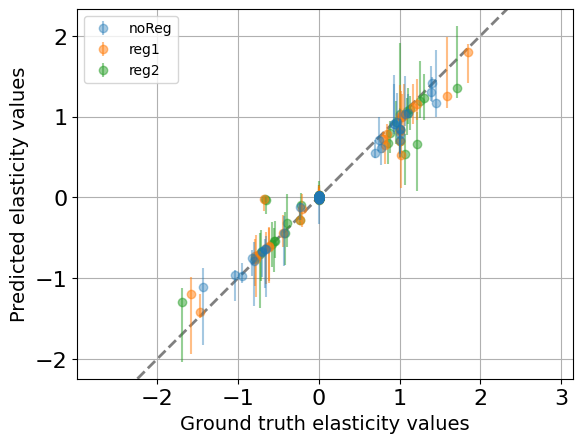

In [18]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gt_noReg, ela_noReg_df['median'], yerr=errors_noReg, alpha=0.4, fmt='o', label='noReg', zorder=100)
plt.errorbar(gt_reg1, ela_reg1_df['median'], yerr=errors_reg1, alpha=0.5, fmt='o', label='reg1', zorder=50)
plt.errorbar(gt_reg2, ela_reg2_df['median'], yerr=errors_reg2, alpha=0.5, fmt='o', label='reg2', zorder=20)
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/elasticities/top{topology}-{omission}-combinedElasticities.svg', format="svg")

## Calculating control coefficients

In [19]:
Ex01_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_noReg)['prior']['Ex'])
Ex02_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_noReg)['prior']['Ex'])
Ex03_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_noReg)['prior']['Ex'])
Ex04_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_noReg)['prior']['Ex'])
Ex05_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_noReg)['prior']['Ex'])
Ex15_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_noReg)['prior']['Ex'])
Ex3_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_noReg)['prior']['Ex'])
Ex5_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_noReg)['prior']['Ex'])
Ex7_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_noReg)['prior']['Ex'])
Ex100_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_noReg)['prior']['Ex'])

Ex01_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_reg1)['prior']['Ex'])
Ex02_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_reg1)['prior']['Ex'])
Ex03_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_reg1)['prior']['Ex'])
Ex04_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_reg1)['prior']['Ex'])
Ex05_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_reg1)['prior']['Ex'])
Ex15_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_reg1)['prior']['Ex'])
Ex3_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_reg1)['prior']['Ex'])
Ex5_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_reg1)['prior']['Ex'])
Ex7_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_reg1)['prior']['Ex'])
Ex100_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_reg1)['prior']['Ex'])

Ex01_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_reg2)['prior']['Ex'])
Ex02_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_reg2)['prior']['Ex'])
Ex03_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_reg2)['prior']['Ex'])
Ex04_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_reg2)['prior']['Ex'])
Ex05_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_reg2)['prior']['Ex'])
Ex15_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_reg2)['prior']['Ex'])
Ex3_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_reg2)['prior']['Ex'])
Ex5_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_reg2)['prior']['Ex'])
Ex7_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_reg2)['prior']['Ex'])
Ex100_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_reg2)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

## Calculating CCC values and making graphs

In [20]:
gtCCC_noReg = pd.DataFrame(rr_noReg.getScaledConcentrationControlCoefficientMatrix(), index=rr_noReg.getFloatingSpeciesIds(), columns=rr_noReg.getReactionIds())
gtCCC_reg1 = pd.DataFrame(rr_reg1.getScaledConcentrationControlCoefficientMatrix(), index=rr_noReg.getFloatingSpeciesIds(), columns=rr_noReg.getReactionIds())
gtCCC_reg2 = pd.DataFrame(rr_reg2.getScaledConcentrationControlCoefficientMatrix(), index=rr_noReg.getFloatingSpeciesIds(), columns=rr_noReg.getReactionIds())

### priors

In [21]:
priorCCC01_noReg = util.estimate_CCCs(BMCA_obj01_noReg, Ex01_prior_noReg.reshape((16,-1)))
priorCCC02_noReg = util.estimate_CCCs(BMCA_obj02_noReg, Ex02_prior_noReg.reshape((16,-1)))
priorCCC03_noReg = util.estimate_CCCs(BMCA_obj03_noReg, Ex03_prior_noReg.reshape((16,-1)))
priorCCC04_noReg = util.estimate_CCCs(BMCA_obj04_noReg, Ex04_prior_noReg.reshape((16,-1)))
priorCCC05_noReg = util.estimate_CCCs(BMCA_obj05_noReg, Ex05_prior_noReg.reshape((16,-1)))
priorCCC15_noReg = util.estimate_CCCs(BMCA_obj15_noReg, Ex15_prior_noReg.reshape((16,-1)))
priorCCC3_noReg = util.estimate_CCCs(BMCA_obj3_noReg, Ex3_prior_noReg.reshape((16,-1)))
priorCCC5_noReg = util.estimate_CCCs(BMCA_obj5_noReg, Ex5_prior_noReg.reshape((16,-1)))
priorCCC7_noReg = util.estimate_CCCs(BMCA_obj7_noReg, Ex7_prior_noReg.reshape((16,-1)))
priorCCC100_noReg = util.estimate_CCCs(BMCA_obj100_noReg, Ex100_prior_noReg.reshape((16,-1)))

priorCCC01_reg1 = util.estimate_CCCs(BMCA_obj01_reg1, Ex01_prior_reg1.reshape((16,-1)))
priorCCC02_reg1 = util.estimate_CCCs(BMCA_obj02_reg1, Ex02_prior_reg1.reshape((16,-1)))
priorCCC03_reg1 = util.estimate_CCCs(BMCA_obj03_reg1, Ex03_prior_reg1.reshape((16,-1)))
priorCCC04_reg1 = util.estimate_CCCs(BMCA_obj04_reg1, Ex04_prior_reg1.reshape((16,-1)))
priorCCC05_reg1 = util.estimate_CCCs(BMCA_obj05_reg1, Ex05_prior_reg1.reshape((16,-1)))
priorCCC15_reg1 = util.estimate_CCCs(BMCA_obj15_reg1, Ex15_prior_reg1.reshape((16,-1)))
priorCCC3_reg1 = util.estimate_CCCs(BMCA_obj3_reg1, Ex3_prior_reg1.reshape((16,-1)))
priorCCC5_reg1 = util.estimate_CCCs(BMCA_obj5_reg1, Ex5_prior_reg1.reshape((16,-1)))
priorCCC7_reg1 = util.estimate_CCCs(BMCA_obj7_reg1, Ex7_prior_reg1.reshape((16,-1)))
priorCCC100_reg1 = util.estimate_CCCs(BMCA_obj100_reg1, Ex100_prior_reg1.reshape((16,-1)))

priorCCC01_reg2 = util.estimate_CCCs(BMCA_obj01_reg2, Ex01_prior_reg2.reshape((16,-1)))
priorCCC02_reg2 = util.estimate_CCCs(BMCA_obj02_reg2, Ex02_prior_reg2.reshape((16,-1)))
priorCCC03_reg2 = util.estimate_CCCs(BMCA_obj03_reg2, Ex03_prior_reg2.reshape((16,-1)))
priorCCC04_reg2 = util.estimate_CCCs(BMCA_obj04_reg2, Ex04_prior_reg2.reshape((16,-1)))
priorCCC05_reg2 = util.estimate_CCCs(BMCA_obj05_reg2, Ex05_prior_reg2.reshape((16,-1)))
priorCCC15_reg2 = util.estimate_CCCs(BMCA_obj15_reg2, Ex15_prior_reg2.reshape((16,-1)))
priorCCC3_reg2 = util.estimate_CCCs(BMCA_obj3_reg2, Ex3_prior_reg2.reshape((16,-1)))
priorCCC5_reg2 = util.estimate_CCCs(BMCA_obj5_reg2, Ex5_prior_reg2.reshape((16,-1)))
priorCCC7_reg2 = util.estimate_CCCs(BMCA_obj7_reg2, Ex7_prior_reg2.reshape((16,-1)))
priorCCC100_reg2 = util.estimate_CCCs(BMCA_obj100_reg2, Ex100_prior_reg2.reshape((16,-1)))


In [22]:
priorCCCs_noReg = [priorCCC01_noReg, priorCCC02_noReg, priorCCC03_noReg, priorCCC04_noReg, priorCCC05_noReg, priorCCC15_noReg, priorCCC3_noReg, priorCCC5_noReg, priorCCC7_noReg, priorCCC100_noReg]
priorCCCs_reg1 = [priorCCC01_reg1, priorCCC02_reg1, priorCCC03_reg1, priorCCC04_reg1, priorCCC05_reg1, priorCCC15_reg1, priorCCC3_reg1, priorCCC5_reg1, priorCCC7_reg1, priorCCC100_reg1]
priorCCCs_reg2 = [priorCCC01_reg2, priorCCC02_reg2, priorCCC03_reg2, priorCCC04_reg2, priorCCC05_reg2, priorCCC15_reg2, priorCCC3_reg2, priorCCC5_reg2, priorCCC7_reg2, priorCCC100_reg2]

In [23]:
priorCCC_noReg_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getFloatingSpeciesIds()) for priorCCC in priorCCCs_noReg]
priorCCC_noReg_meds = pd.concat([i.melt()['value'] for i in priorCCC_noReg_meds], axis=1).values
priorCCC_noReg_meds = pd.DataFrame(priorCCC_noReg_meds, columns=pt_labels)
priorCCC_noReg_meds['median'] = priorCCC_noReg_meds.median(axis=1)
priorCCC_noReg_meds['min'] = priorCCC_noReg_meds.min(axis=1)
priorCCC_noReg_meds['max'] = priorCCC_noReg_meds.max(axis=1)
# priorCCC_noReg_meds

In [24]:
priorCCC_reg1_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getFloatingSpeciesIds()) for priorCCC in priorCCCs_reg1]
priorCCC_reg1_meds = pd.concat([i.melt()['value'] for i in priorCCC_reg1_meds], axis=1).values
priorCCC_reg1_meds = pd.DataFrame(priorCCC_reg1_meds, columns=pt_labels)
priorCCC_reg1_meds['median'] = priorCCC_reg1_meds.median(axis=1)
priorCCC_reg1_meds['min'] = priorCCC_reg1_meds.min(axis=1)
priorCCC_reg1_meds['max'] = priorCCC_reg1_meds.max(axis=1)
# priorCCC_reg1_meds

In [25]:
priorCCC_reg2_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getFloatingSpeciesIds()) for priorCCC in priorCCCs_reg2]
priorCCC_reg2_meds = pd.concat([i.melt()['value'] for i in priorCCC_reg2_meds], axis=1).values
priorCCC_reg2_meds = pd.DataFrame(priorCCC_reg2_meds, columns=pt_labels)
priorCCC_reg2_meds['median'] = priorCCC_reg2_meds.median(axis=1)
priorCCC_reg2_meds['min'] = priorCCC_reg2_meds.min(axis=1)
priorCCC_reg2_meds['max'] = priorCCC_reg2_meds.max(axis=1)
# priorCCC_reg2_meds

In [26]:
CCC_lower_y_noReg_prior = np.array(priorCCC_noReg_meds['median']) - np.array(priorCCC_noReg_meds['min'])
CCC_upper_y_noReg_prior = np.array(priorCCC_noReg_meds['max']) - np.array(priorCCC_noReg_meds['median'])
CCC_errors_noReg_prior = [CCC_lower_y_noReg_prior, CCC_upper_y_noReg_prior]

CCC_lower_y_reg1_prior = np.array(priorCCC_reg1_meds['median']) - np.array(priorCCC_reg1_meds['min'])
CCC_upper_y_reg1_prior = np.array(priorCCC_reg1_meds['max']) - np.array(priorCCC_reg1_meds['median'])
CCC_errors_reg1_prior = [CCC_lower_y_reg1_prior, CCC_upper_y_reg1_prior]

CCC_lower_y_reg2_prior = np.array(priorCCC_reg2_meds['median']) - np.array(priorCCC_reg2_meds['min'])
CCC_upper_y_reg2_prior = np.array(priorCCC_reg2_meds['max']) - np.array(priorCCC_reg2_meds['median'])
CCC_errors_reg2_prior = [CCC_lower_y_reg2_prior, CCC_upper_y_reg2_prior]

### posteriors

In [27]:
# all data
postCCC01_noReg = util.estimate_CCCs(BMCA_obj01_noReg, Ex01_noReg.reshape((16, -1)))
postCCC02_noReg = util.estimate_CCCs(BMCA_obj02_noReg, Ex02_noReg.reshape((16, -1)))
postCCC03_noReg = util.estimate_CCCs(BMCA_obj03_noReg, Ex03_noReg.reshape((16, -1)))
postCCC04_noReg = util.estimate_CCCs(BMCA_obj04_noReg, Ex04_noReg.reshape((16, -1)))
postCCC05_noReg = util.estimate_CCCs(BMCA_obj05_noReg, Ex05_noReg.reshape((16, -1)))
postCCC15_noReg = util.estimate_CCCs(BMCA_obj15_noReg, Ex15_noReg.reshape((16, -1)))
postCCC3_noReg = util.estimate_CCCs(BMCA_obj3_noReg, Ex3_noReg.reshape((16, -1)))
postCCC5_noReg = util.estimate_CCCs(BMCA_obj5_noReg, Ex5_noReg.reshape((16, -1)))
postCCC7_noReg = util.estimate_CCCs(BMCA_obj7_noReg, Ex7_noReg.reshape((16, -1)))
postCCC100_noReg = util.estimate_CCCs(BMCA_obj100_noReg, Ex100_noReg.reshape((16, -1)))

postCCC01_reg1 = util.estimate_CCCs(BMCA_obj01_reg1, Ex01_reg1.reshape((16, -1)))
postCCC02_reg1 = util.estimate_CCCs(BMCA_obj02_reg1, Ex02_reg1.reshape((16, -1)))
postCCC03_reg1 = util.estimate_CCCs(BMCA_obj03_reg1, Ex03_reg1.reshape((16, -1)))
postCCC04_reg1 = util.estimate_CCCs(BMCA_obj04_reg1, Ex04_reg1.reshape((16, -1)))
postCCC05_reg1 = util.estimate_CCCs(BMCA_obj05_reg1, Ex05_reg1.reshape((16, -1)))
postCCC15_reg1 = util.estimate_CCCs(BMCA_obj15_reg1, Ex15_reg1.reshape((16, -1)))
postCCC3_reg1 = util.estimate_CCCs(BMCA_obj3_reg1, Ex3_reg1.reshape((16, -1)))
postCCC5_reg1 = util.estimate_CCCs(BMCA_obj5_reg1, Ex5_reg1.reshape((16, -1)))
postCCC7_reg1 = util.estimate_CCCs(BMCA_obj7_reg1, Ex7_reg1.reshape((16, -1)))
postCCC100_reg1 = util.estimate_CCCs(BMCA_obj100_reg1, Ex100_reg1.reshape((16, -1)))

postCCC01_reg2 = util.estimate_CCCs(BMCA_obj01_reg2, Ex01_reg2.reshape((16, -1)))
postCCC02_reg2 = util.estimate_CCCs(BMCA_obj02_reg2, Ex02_reg2.reshape((16, -1)))
postCCC03_reg2 = util.estimate_CCCs(BMCA_obj03_reg2, Ex03_reg2.reshape((16, -1)))
postCCC04_reg2 = util.estimate_CCCs(BMCA_obj04_reg2, Ex04_reg2.reshape((16, -1)))
postCCC05_reg2 = util.estimate_CCCs(BMCA_obj05_reg2, Ex05_reg2.reshape((16, -1)))
postCCC15_reg2 = util.estimate_CCCs(BMCA_obj15_reg2, Ex15_reg2.reshape((16, -1)))
postCCC3_reg2 = util.estimate_CCCs(BMCA_obj3_reg2, Ex3_reg2.reshape((16, -1)))
postCCC5_reg2 = util.estimate_CCCs(BMCA_obj5_reg2, Ex5_reg2.reshape((16, -1)))
postCCC7_reg2 = util.estimate_CCCs(BMCA_obj7_reg2, Ex7_reg2.reshape((16, -1)))
postCCC100_reg2 = util.estimate_CCCs(BMCA_obj100_reg2, Ex100_reg2.reshape((16, -1)))

In [28]:
postCCCs_noReg = [postCCC01_noReg, postCCC02_noReg, postCCC03_noReg, postCCC04_noReg, postCCC05_noReg, postCCC15_noReg, postCCC3_noReg, postCCC5_noReg, postCCC7_noReg, postCCC100_noReg]
postCCCs_reg1 = [postCCC01_reg1, postCCC02_reg1, postCCC03_reg1, postCCC04_reg1, postCCC05_reg1, postCCC15_reg1, postCCC3_reg1, postCCC5_reg1, postCCC7_reg1, postCCC100_reg1]
postCCCs_reg2 = [postCCC01_reg2, postCCC02_reg2, postCCC03_reg2, postCCC04_reg2, postCCC05_reg2, postCCC15_reg2, postCCC3_reg2, postCCC5_reg2, postCCC7_reg2, postCCC100_reg2]

In [29]:
postCCC_noReg_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getFloatingSpeciesIds()) for postCCC in postCCCs_noReg]
postCCC_noReg_meds = pd.concat([i.melt()['value'] for i in postCCC_noReg_meds], axis=1).values
postCCC_noReg_meds = pd.DataFrame(postCCC_noReg_meds, columns=pt_labels)
postCCC_noReg_meds['median'] = postCCC_noReg_meds.median(axis=1)
postCCC_noReg_meds['min'] = postCCC_noReg_meds.min(axis=1)
postCCC_noReg_meds['max'] = postCCC_noReg_meds.max(axis=1)
# postCCC_noReg_meds

In [30]:
postCCC_reg1_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getFloatingSpeciesIds()) for postCCC in postCCCs_reg1]
postCCC_reg1_meds = pd.concat([i.melt()['value'] for i in postCCC_reg1_meds], axis=1).values
postCCC_reg1_meds = pd.DataFrame(postCCC_reg1_meds, columns=pt_labels)
postCCC_reg1_meds['median'] = postCCC_reg1_meds.median(axis=1)
postCCC_reg1_meds['min'] = postCCC_reg1_meds.min(axis=1)
postCCC_reg1_meds['max'] = postCCC_reg1_meds.max(axis=1)
# postCCC_reg1_meds

In [31]:
postCCC_reg2_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getFloatingSpeciesIds()) for postCCC in postCCCs_reg2]
postCCC_reg2_meds = pd.concat([i.melt()['value'] for i in postCCC_reg2_meds], axis=1).values
postCCC_reg2_meds = pd.DataFrame(postCCC_reg2_meds, columns=pt_labels)
postCCC_reg2_meds['median'] = postCCC_reg2_meds.median(axis=1)
postCCC_reg2_meds['min'] = postCCC_reg2_meds.min(axis=1)
postCCC_reg2_meds['max'] = postCCC_reg2_meds.max(axis=1)
# postCCC_reg2_meds

In [32]:
CCC_lower_y_noReg_post = np.array(postCCC_noReg_meds['median']) - np.array(postCCC_noReg_meds['min'])
CCC_upper_y_noReg_post = np.array(postCCC_noReg_meds['max']) - np.array(postCCC_noReg_meds['median'])
CCC_errors_noReg_post = [CCC_lower_y_noReg_post, CCC_upper_y_noReg_post]

CCC_lower_y_reg1_post = np.array(postCCC_reg1_meds['median']) - np.array(postCCC_reg1_meds['min'])
CCC_upper_y_reg1_post = np.array(postCCC_reg1_meds['max']) - np.array(postCCC_reg1_meds['median'])
CCC_errors_reg1_post = [CCC_lower_y_reg1_post, CCC_upper_y_reg1_post]

CCC_lower_y_reg2_post = np.array(postCCC_reg2_meds['median']) - np.array(postCCC_reg2_meds['min'])
CCC_upper_y_reg2_post = np.array(postCCC_reg2_meds['max']) - np.array(postCCC_reg2_meds['median'])
CCC_errors_reg2_post = [CCC_lower_y_reg2_post, CCC_upper_y_reg2_post]

### graphs

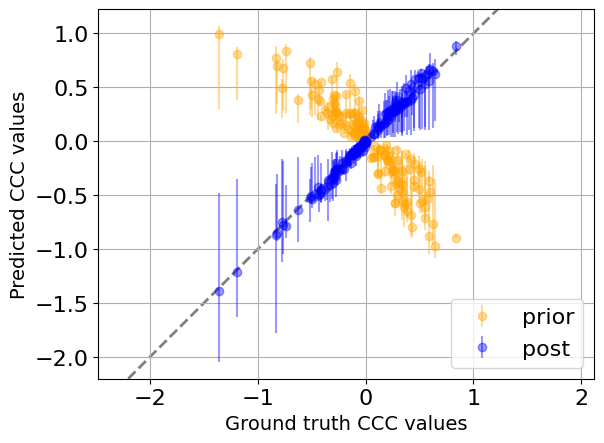

In [33]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_noReg.melt()['value'], priorCCC_noReg_meds['median'], yerr=CCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], yerr=CCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth CCC values', size=14)
plt.ylabel('Predicted CCC values', size=14)

plt.legend(loc="lower right", fontsize=16)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/CCCs/top{topology}-{omission}-medianCCCs_noReg.svg', format="svg")

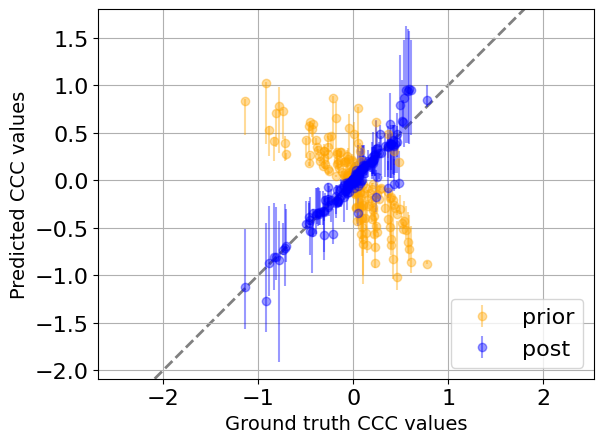

In [34]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'], yerr=CCC_errors_reg1_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], yerr=CCC_errors_reg1_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')


plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth CCC values', size=14)
plt.ylabel('Predicted CCC values', size=14)

plt.legend(loc="lower right", fontsize=16)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/CCCs/top{topology}-{omission}-medianCCCs_reg1.svg', format="svg")

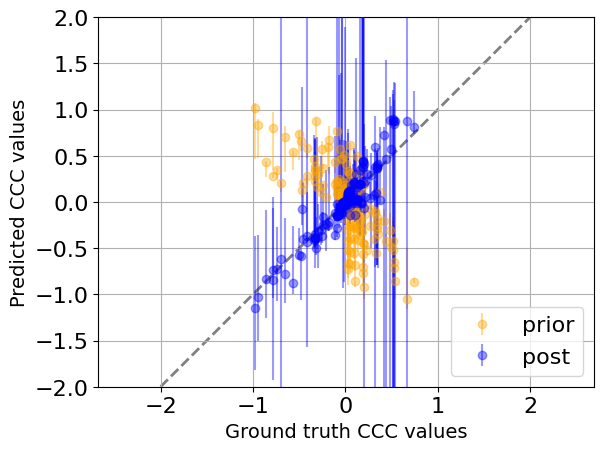

In [35]:
plt.axes().set_aspect('equal', 'datalim')

plt.ylim((-2,2))

plt.errorbar(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'], yerr=CCC_errors_reg2_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], yerr=CCC_errors_reg2_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth CCC values', size=14)
plt.ylabel('Predicted CCC values', size=14)

plt.legend(loc="lower right", fontsize=16)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/CCCs/top{topology}-{omission}-medianCCCs_reg2.svg', format="svg")

### combined graph of CCC values

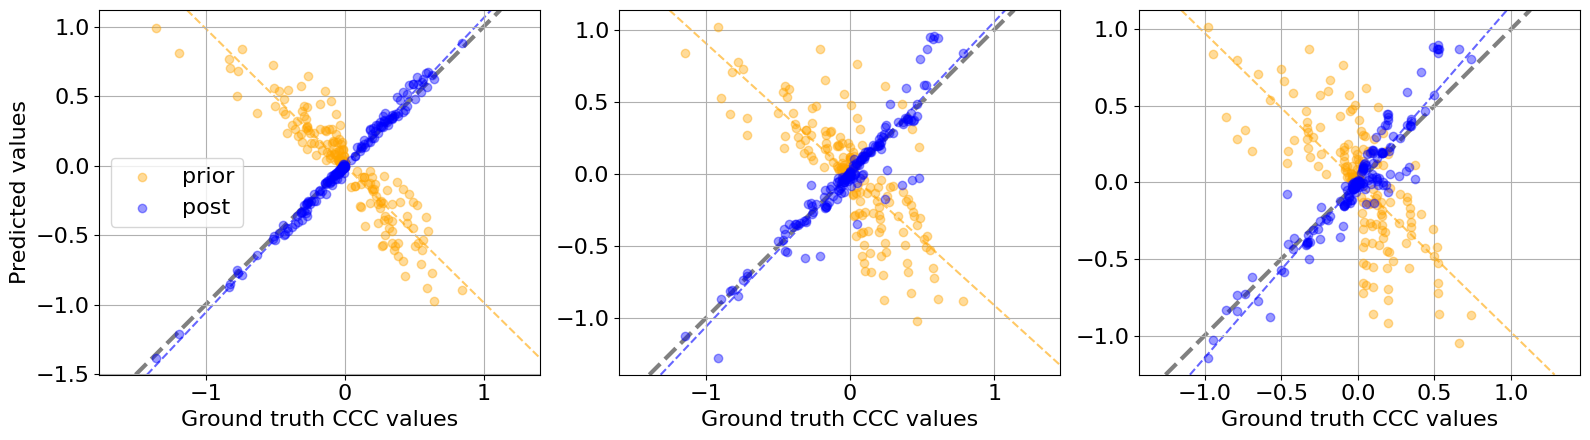

In [36]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(1, 3, figsize=(16,4.5))

for ii in range(3):
    ax[ii].tick_params(axis='both', which='major', labelsize=16)

ax[0].set_aspect('equal', 'datalim')
ax[0].scatter(gtCCC_noReg.melt()['value'], priorCCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0].scatter(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], priorCCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].grid()
ax[0].legend(loc="center left", fontsize=16)
ax[0].set_xlabel('Ground truth CCC values', fontsize=16)

ax[1].set_aspect('equal', 'datalim')
ax[1].scatter(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1].scatter(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].grid()
ax[1].set_xlabel('Ground truth CCC values', fontsize=16)

ax[2].set_aspect('equal', 'datalim')
ax[2].scatter(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[2].scatter(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].grid()

ax[2].set_xlabel('Ground truth CCC values', fontsize=16)
ax[0].set_ylabel('Predicted values', fontsize=16)
  
f.tight_layout()

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/CCCs/top{topology}-{omission}-combinedCCCs.svg', format="svg")

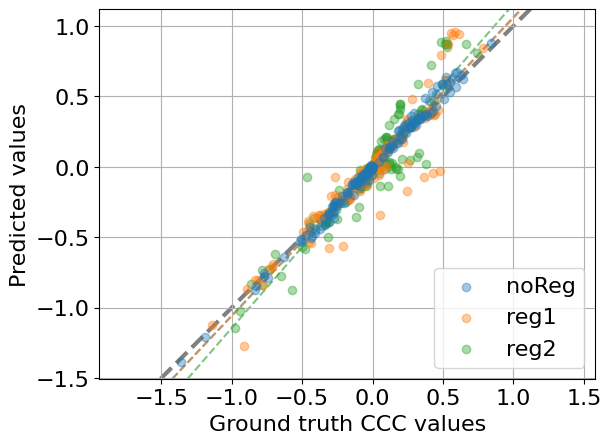

In [37]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], alpha=0.4, label='noReg', zorder=300)
plt.scatter(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], alpha=0.4,  label='reg1', zorder=200)
plt.scatter(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], alpha=0.4,  label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('Ground truth CCC values', fontsize=16)
plt.ylabel('Predicted values', fontsize=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

# plt.ylim(-5,5)

f.tight_layout()

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/CCCs/top{topology}-{omission}-combinedCCCs_byAllostery.svg', format="svg")

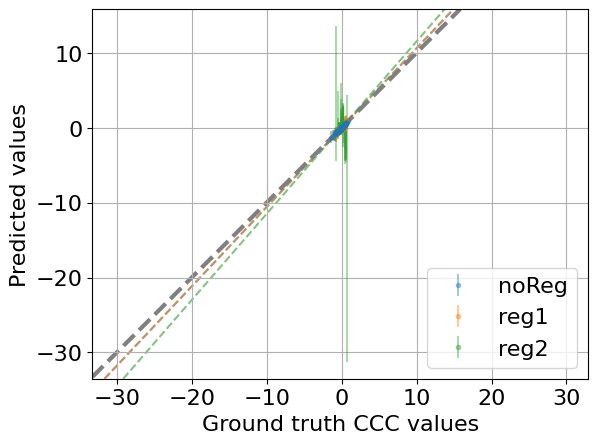

In [38]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], yerr=CCC_errors_noReg_post, alpha=0.4, fmt='o', markersize=3, label='noReg', zorder=300)
plt.errorbar(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], yerr=CCC_errors_reg1_post, alpha=0.4, fmt='o', markersize=3, label='reg1', zorder=200)
plt.errorbar(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], yerr=CCC_errors_reg2_post, alpha=0.4, fmt='o', markersize=3, label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('Ground truth CCC values', fontsize=16)
plt.ylabel('Predicted values', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/CCCs/top{topology}-{omission}-combinedCCCs_byAllostery_wError.svg', format="svg")

## Calculating FCC values and making graphs

In [39]:
gtFCC_noReg = pd.DataFrame(rr_noReg.getScaledFluxControlCoefficientMatrix(), index=rr_noReg.getReactionIds(), columns=rr_noReg.getReactionIds())
gtFCC_reg1 = pd.DataFrame(rr_reg1.getScaledFluxControlCoefficientMatrix(), index=rr_noReg.getReactionIds(), columns=rr_noReg.getReactionIds())
gtFCC_reg2 = pd.DataFrame(rr_reg2.getScaledFluxControlCoefficientMatrix(), index=rr_noReg.getReactionIds(), columns=rr_noReg.getReactionIds())

### priors

In [40]:
priorFCC01_noReg = util.estimate_FCCs(BMCA_obj01_noReg, Ex01_prior_noReg.reshape((16,-1)))
priorFCC02_noReg = util.estimate_FCCs(BMCA_obj02_noReg, Ex02_prior_noReg.reshape((16,-1)))
priorFCC03_noReg = util.estimate_FCCs(BMCA_obj03_noReg, Ex03_prior_noReg.reshape((16,-1)))
priorFCC04_noReg = util.estimate_FCCs(BMCA_obj04_noReg, Ex04_prior_noReg.reshape((16,-1)))
priorFCC05_noReg = util.estimate_FCCs(BMCA_obj05_noReg, Ex05_prior_noReg.reshape((16,-1)))
priorFCC15_noReg = util.estimate_FCCs(BMCA_obj15_noReg, Ex15_prior_noReg.reshape((16,-1)))
priorFCC3_noReg = util.estimate_FCCs(BMCA_obj3_noReg, Ex3_prior_noReg.reshape((16,-1)))
priorFCC5_noReg = util.estimate_FCCs(BMCA_obj5_noReg, Ex5_prior_noReg.reshape((16,-1)))
priorFCC7_noReg = util.estimate_FCCs(BMCA_obj7_noReg, Ex7_prior_noReg.reshape((16,-1)))
priorFCC100_noReg = util.estimate_FCCs(BMCA_obj100_noReg, Ex100_prior_noReg.reshape((16,-1)))

priorFCC01_reg1 = util.estimate_FCCs(BMCA_obj01_reg1, Ex01_prior_reg1.reshape((16,-1)))
priorFCC02_reg1 = util.estimate_FCCs(BMCA_obj02_reg1, Ex02_prior_reg1.reshape((16,-1)))
priorFCC03_reg1 = util.estimate_FCCs(BMCA_obj03_reg1, Ex03_prior_reg1.reshape((16,-1)))
priorFCC04_reg1 = util.estimate_FCCs(BMCA_obj04_reg1, Ex04_prior_reg1.reshape((16,-1)))
priorFCC05_reg1 = util.estimate_FCCs(BMCA_obj05_reg1, Ex05_prior_reg1.reshape((16,-1)))
priorFCC15_reg1 = util.estimate_FCCs(BMCA_obj15_reg1, Ex15_prior_reg1.reshape((16,-1)))
priorFCC3_reg1 = util.estimate_FCCs(BMCA_obj3_reg1, Ex3_prior_reg1.reshape((16,-1)))
priorFCC5_reg1 = util.estimate_FCCs(BMCA_obj5_reg1, Ex5_prior_reg1.reshape((16,-1)))
priorFCC7_reg1 = util.estimate_FCCs(BMCA_obj7_reg1, Ex7_prior_reg1.reshape((16,-1)))
priorFCC100_reg1 = util.estimate_FCCs(BMCA_obj100_reg1, Ex100_prior_reg1.reshape((16,-1)))

priorFCC01_reg2 = util.estimate_FCCs(BMCA_obj01_reg2, Ex01_prior_reg2.reshape((16,-1)))
priorFCC02_reg2 = util.estimate_FCCs(BMCA_obj02_reg2, Ex02_prior_reg2.reshape((16,-1)))
priorFCC03_reg2 = util.estimate_FCCs(BMCA_obj03_reg2, Ex03_prior_reg2.reshape((16,-1)))
priorFCC04_reg2 = util.estimate_FCCs(BMCA_obj04_reg2, Ex04_prior_reg2.reshape((16,-1)))
priorFCC05_reg2 = util.estimate_FCCs(BMCA_obj05_reg2, Ex05_prior_reg2.reshape((16,-1)))
priorFCC15_reg2 = util.estimate_FCCs(BMCA_obj15_reg2, Ex15_prior_reg2.reshape((16,-1)))
priorFCC3_reg2 = util.estimate_FCCs(BMCA_obj3_reg2, Ex3_prior_reg2.reshape((16,-1)))
priorFCC5_reg2 = util.estimate_FCCs(BMCA_obj5_reg2, Ex5_prior_reg2.reshape((16,-1)))
priorFCC7_reg2 = util.estimate_FCCs(BMCA_obj7_reg2, Ex7_prior_reg2.reshape((16,-1)))
priorFCC100_reg2 = util.estimate_FCCs(BMCA_obj100_reg2, Ex100_prior_reg2.reshape((16,-1)))


In [41]:
priorFCCs_noReg = [priorFCC01_noReg, priorFCC02_noReg, priorFCC03_noReg, priorFCC04_noReg, priorFCC05_noReg, priorFCC15_noReg, priorFCC3_noReg, priorFCC5_noReg, priorFCC7_noReg, priorFCC100_noReg]
priorFCCs_reg1 = [priorFCC01_reg1, priorFCC02_reg1, priorFCC03_reg1, priorFCC04_reg1, priorFCC05_reg1, priorFCC15_reg1, priorFCC3_reg1, priorFCC5_reg1, priorFCC7_reg1, priorFCC100_reg1]
priorFCCs_reg2 = [priorFCC01_reg2, priorFCC02_reg2, priorFCC03_reg2, priorFCC04_reg2, priorFCC05_reg2, priorFCC15_reg2, priorFCC3_reg2, priorFCC5_reg2, priorFCC7_reg2, priorFCC100_reg2]

In [42]:
priorFCC_noReg_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getReactionIds()) for priorFCC in priorFCCs_noReg]
priorFCC_noReg_meds = pd.concat([i.melt()['value'] for i in priorFCC_noReg_meds], axis=1).values
priorFCC_noReg_meds = pd.DataFrame(priorFCC_noReg_meds, columns=pt_labels)
priorFCC_noReg_meds['median'] = priorFCC_noReg_meds.median(axis=1)
priorFCC_noReg_meds['min'] = priorFCC_noReg_meds.min(axis=1)
priorFCC_noReg_meds['max'] = priorFCC_noReg_meds.max(axis=1)
# priorFCC_noReg_meds

In [43]:
priorFCC_reg1_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getReactionIds()) for priorFCC in priorFCCs_reg1]
priorFCC_reg1_meds = pd.concat([i.melt()['value'] for i in priorFCC_reg1_meds], axis=1).values
priorFCC_reg1_meds = pd.DataFrame(priorFCC_reg1_meds, columns=pt_labels)
priorFCC_reg1_meds['median'] = priorFCC_reg1_meds.median(axis=1)
priorFCC_reg1_meds['min'] = priorFCC_reg1_meds.min(axis=1)
priorFCC_reg1_meds['max'] = priorFCC_reg1_meds.max(axis=1)
# priorFCC_reg1_meds

In [44]:
priorFCC_reg2_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getReactionIds()) for priorFCC in priorFCCs_reg2]
priorFCC_reg2_meds = pd.concat([i.melt()['value'] for i in priorFCC_reg2_meds], axis=1).values
priorFCC_reg2_meds = pd.DataFrame(priorFCC_reg2_meds, columns=pt_labels)
priorFCC_reg2_meds['median'] = priorFCC_reg2_meds.median(axis=1)
priorFCC_reg2_meds['min'] = priorFCC_reg2_meds.min(axis=1)
priorFCC_reg2_meds['max'] = priorFCC_reg2_meds.max(axis=1)
# priorFCC_reg2_meds

In [45]:
FCC_lower_y_noReg_prior = np.array(priorFCC_noReg_meds['median']) - np.array(priorFCC_noReg_meds['min'])
FCC_upper_y_noReg_prior = np.array(priorFCC_noReg_meds['max']) - np.array(priorFCC_noReg_meds['median'])
FCC_errors_noReg_prior = [FCC_lower_y_noReg_prior, FCC_upper_y_noReg_prior]

FCC_lower_y_reg1_prior = np.array(priorFCC_reg1_meds['median']) - np.array(priorFCC_reg1_meds['min'])
FCC_upper_y_reg1_prior = np.array(priorFCC_reg1_meds['max']) - np.array(priorFCC_reg1_meds['median'])
FCC_errors_reg1_prior = [FCC_lower_y_reg1_prior, FCC_upper_y_reg1_prior]

FCC_lower_y_reg2_prior = np.array(priorFCC_reg2_meds['median']) - np.array(priorFCC_reg2_meds['min'])
FCC_upper_y_reg2_prior = np.array(priorFCC_reg2_meds['max']) - np.array(priorFCC_reg2_meds['median'])
FCC_errors_reg2_prior = [FCC_lower_y_reg2_prior, FCC_upper_y_reg2_prior]

### posteriors

In [46]:
# all data
postFCC01_noReg = util.estimate_FCCs(BMCA_obj01_noReg, Ex01_noReg.reshape((16, -1)))
postFCC02_noReg = util.estimate_FCCs(BMCA_obj02_noReg, Ex02_noReg.reshape((16, -1)))
postFCC03_noReg = util.estimate_FCCs(BMCA_obj03_noReg, Ex03_noReg.reshape((16, -1)))
postFCC04_noReg = util.estimate_FCCs(BMCA_obj04_noReg, Ex04_noReg.reshape((16, -1)))
postFCC05_noReg = util.estimate_FCCs(BMCA_obj05_noReg, Ex05_noReg.reshape((16, -1)))
postFCC15_noReg = util.estimate_FCCs(BMCA_obj15_noReg, Ex15_noReg.reshape((16, -1)))
postFCC3_noReg = util.estimate_FCCs(BMCA_obj3_noReg, Ex3_noReg.reshape((16, -1)))
postFCC5_noReg = util.estimate_FCCs(BMCA_obj5_noReg, Ex5_noReg.reshape((16, -1)))
postFCC7_noReg = util.estimate_FCCs(BMCA_obj7_noReg, Ex7_noReg.reshape((16, -1)))
postFCC100_noReg = util.estimate_FCCs(BMCA_obj100_noReg, Ex100_noReg.reshape((16, -1)))

postFCC01_reg1 = util.estimate_FCCs(BMCA_obj01_reg1, Ex01_reg1.reshape((16, -1)))
postFCC02_reg1 = util.estimate_FCCs(BMCA_obj02_reg1, Ex02_reg1.reshape((16, -1)))
postFCC03_reg1 = util.estimate_FCCs(BMCA_obj03_reg1, Ex03_reg1.reshape((16, -1)))
postFCC04_reg1 = util.estimate_FCCs(BMCA_obj04_reg1, Ex04_reg1.reshape((16, -1)))
postFCC05_reg1 = util.estimate_FCCs(BMCA_obj05_reg1, Ex05_reg1.reshape((16, -1)))
postFCC15_reg1 = util.estimate_FCCs(BMCA_obj15_reg1, Ex15_reg1.reshape((16, -1)))
postFCC3_reg1 = util.estimate_FCCs(BMCA_obj3_reg1, Ex3_reg1.reshape((16, -1)))
postFCC5_reg1 = util.estimate_FCCs(BMCA_obj5_reg1, Ex5_reg1.reshape((16, -1)))
postFCC7_reg1 = util.estimate_FCCs(BMCA_obj7_reg1, Ex7_reg1.reshape((16, -1)))
postFCC100_reg1 = util.estimate_FCCs(BMCA_obj100_reg1, Ex100_reg1.reshape((16, -1)))

postFCC01_reg2 = util.estimate_FCCs(BMCA_obj01_reg2, Ex01_reg2.reshape((16, -1)))
postFCC02_reg2 = util.estimate_FCCs(BMCA_obj02_reg2, Ex02_reg2.reshape((16, -1)))
postFCC03_reg2 = util.estimate_FCCs(BMCA_obj03_reg2, Ex03_reg2.reshape((16, -1)))
postFCC04_reg2 = util.estimate_FCCs(BMCA_obj04_reg2, Ex04_reg2.reshape((16, -1)))
postFCC05_reg2 = util.estimate_FCCs(BMCA_obj05_reg2, Ex05_reg2.reshape((16, -1)))
postFCC15_reg2 = util.estimate_FCCs(BMCA_obj15_reg2, Ex15_reg2.reshape((16, -1)))
postFCC3_reg2 = util.estimate_FCCs(BMCA_obj3_reg2, Ex3_reg2.reshape((16, -1)))
postFCC5_reg2 = util.estimate_FCCs(BMCA_obj5_reg2, Ex5_reg2.reshape((16, -1)))
postFCC7_reg2 = util.estimate_FCCs(BMCA_obj7_reg2, Ex7_reg2.reshape((16, -1)))
postFCC100_reg2 = util.estimate_FCCs(BMCA_obj100_reg2, Ex100_reg2.reshape((16, -1)))

In [47]:
postFCCs_noReg = [postFCC01_noReg, postFCC02_noReg, postFCC03_noReg, postFCC04_noReg, postFCC05_noReg, postFCC15_noReg, postFCC3_noReg, postFCC5_noReg, postFCC7_noReg, postFCC100_noReg]
postFCCs_reg1 = [postFCC01_reg1, postFCC02_reg1, postFCC03_reg1, postFCC04_reg1, postFCC05_reg1, postFCC15_reg1, postFCC3_reg1, postFCC5_reg1, postFCC7_reg1, postFCC100_reg1]
postFCCs_reg2 = [postFCC01_reg2, postFCC02_reg2, postFCC03_reg2, postFCC04_reg2, postFCC05_reg2, postFCC15_reg2, postFCC3_reg2, postFCC5_reg2, postFCC7_reg2, postFCC100_reg2]

In [48]:
# omit enzymes
def estimate_CCs(BMCA_obj, Ex, med_et_advi):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(med_et_advi / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(3000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(3000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(3000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC


In [49]:
postFCC_noReg_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getReactionIds()) for postFCC in postFCCs_noReg]
postFCC_noReg_meds = pd.concat([i.melt()['value'] for i in postFCC_noReg_meds], axis=1).values
postFCC_noReg_meds = pd.DataFrame(postFCC_noReg_meds, columns=pt_labels)
postFCC_noReg_meds['median'] = postFCC_noReg_meds.median(axis=1)
postFCC_noReg_meds['min'] = postFCC_noReg_meds.min(axis=1)
postFCC_noReg_meds['max'] = postFCC_noReg_meds.max(axis=1)
# postFCC_noReg_meds

In [50]:
postFCC_reg1_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getReactionIds()) for postFCC in postFCCs_reg1]
postFCC_reg1_meds = pd.concat([i.melt()['value'] for i in postFCC_reg1_meds], axis=1).values
postFCC_reg1_meds = pd.DataFrame(postFCC_reg1_meds, columns=pt_labels)
postFCC_reg1_meds['median'] = postFCC_reg1_meds.median(axis=1)
postFCC_reg1_meds['min'] = postFCC_reg1_meds.min(axis=1)
postFCC_reg1_meds['max'] = postFCC_reg1_meds.max(axis=1)
# postFCC_reg1_meds

In [51]:
postFCC_reg2_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getReactionIds()) for postFCC in postFCCs_reg2]
postFCC_reg2_meds = pd.concat([i.melt()['value'] for i in postFCC_reg2_meds], axis=1).values
postFCC_reg2_meds = pd.DataFrame(postFCC_reg2_meds, columns=pt_labels)
postFCC_reg2_meds['median'] = postFCC_reg2_meds.median(axis=1)
postFCC_reg2_meds['min'] = postFCC_reg2_meds.min(axis=1)
postFCC_reg2_meds['max'] = postFCC_reg2_meds.max(axis=1)
# postFCC_reg2_meds

In [52]:
FCC_lower_y_noReg_post = np.array(postFCC_noReg_meds['median']) - np.array(postFCC_noReg_meds['min'])
FCC_upper_y_noReg_post = np.array(postFCC_noReg_meds['max']) - np.array(postFCC_noReg_meds['median'])
FCC_errors_noReg_post = [FCC_lower_y_noReg_post, FCC_upper_y_noReg_post]

FCC_lower_y_reg1_post = np.array(postFCC_reg1_meds['median']) - np.array(postFCC_reg1_meds['min'])
FCC_upper_y_reg1_post = np.array(postFCC_reg1_meds['max']) - np.array(postFCC_reg1_meds['median'])
FCC_errors_reg1_post = [FCC_lower_y_reg1_post, FCC_upper_y_reg1_post]

FCC_lower_y_reg2_post = np.array(postFCC_reg2_meds['median']) - np.array(postFCC_reg2_meds['min'])
FCC_upper_y_reg2_post = np.array(postFCC_reg2_meds['max']) - np.array(postFCC_reg2_meds['median'])
FCC_errors_reg2_post = [FCC_lower_y_reg2_post, FCC_upper_y_reg2_post]

### graphs

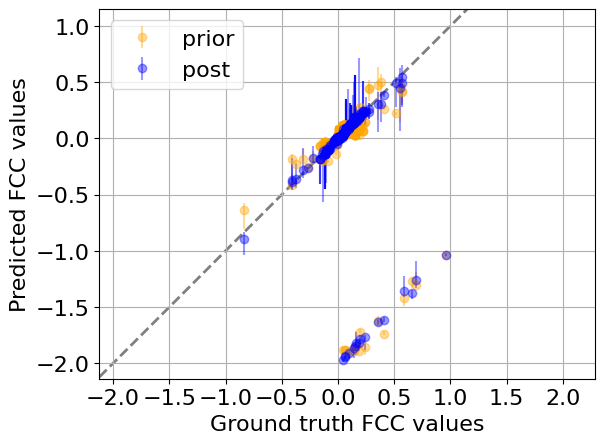

In [53]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], yerr=FCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left", fontsize=16)
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=16)
plt.ylabel('Predicted FCC values', size=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-medianFCCs_noReg.svg', format="svg")

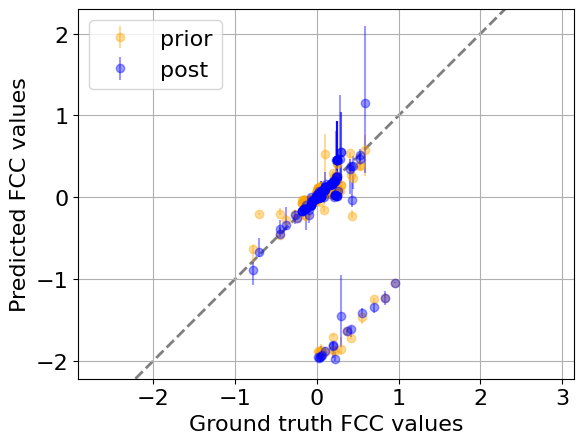

In [54]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], yerr=FCC_errors_reg1_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], yerr=FCC_errors_reg1_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left", fontsize=16)
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=16)
plt.ylabel('Predicted FCC values', size=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-medianFCCs_reg1.svg', format="svg")

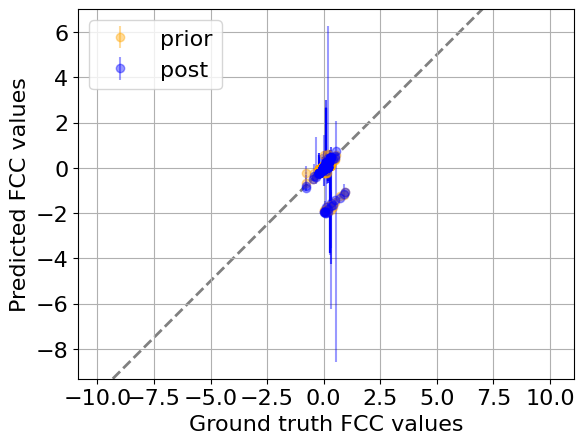

In [55]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], yerr=FCC_errors_reg2_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], yerr=FCC_errors_reg2_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left", fontsize=16)
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=16)
plt.ylabel('Predicted FCC values', size=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-medianFCCs_reg2.svg', format="svg")

### adding corrections for where the enzyme perturbed is directly involved in the reaction

In [56]:
rxn = np.repeat(rr_noReg.getReactionIds(),len(rr_noReg.getReactionIds()))
enz_pt = rr_noReg.getReactionIds() * len(rr_noReg.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

In [57]:
pt_enz_is_rxn = np.linspace(0,len(rxn)-1,len(rr_noReg.getReactionIds()))
pt_enz_is_rxn

array([  0.,  17.,  34.,  51.,  68.,  85., 102., 119., 136., 153., 170.,
       187., 204., 221., 238., 255.])

### graphing the corrected fcc dfs

In [58]:
priorFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2

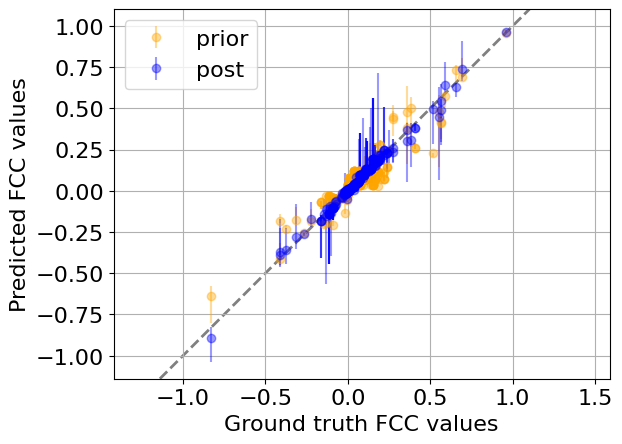

In [59]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], yerr=FCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left", fontsize=16)
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=16)
plt.ylabel('Predicted FCC values', size=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-medianFCCs_noReg_wCorrection.svg', format="svg")

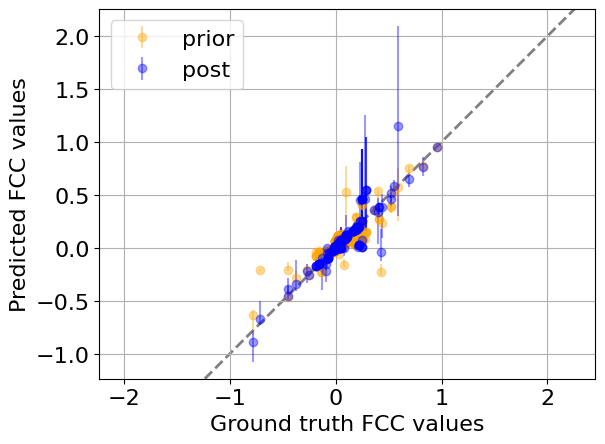

In [60]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], yerr=FCC_errors_reg1_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], yerr=FCC_errors_reg1_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left", fontsize=16)
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=16)
plt.ylabel('Predicted FCC values', size=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-medianFCCs_reg1_wCorrection.svg', format="svg")

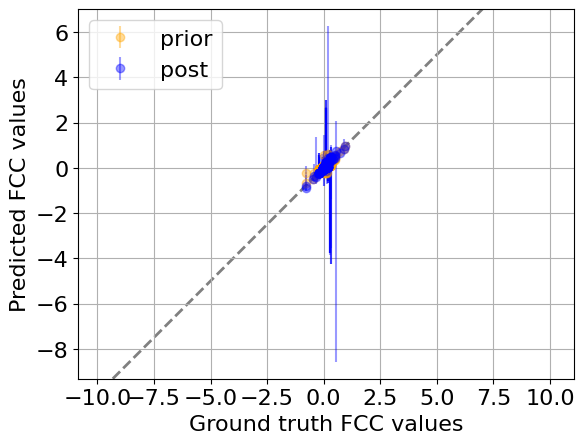

In [61]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], yerr=FCC_errors_reg2_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], yerr=FCC_errors_reg2_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left", fontsize=16)
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=16)
plt.ylabel('Predicted FCC values', size=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-medianFCCs_reg2_wCorrection.svg', format="svg")

### Combined graph of FCC values

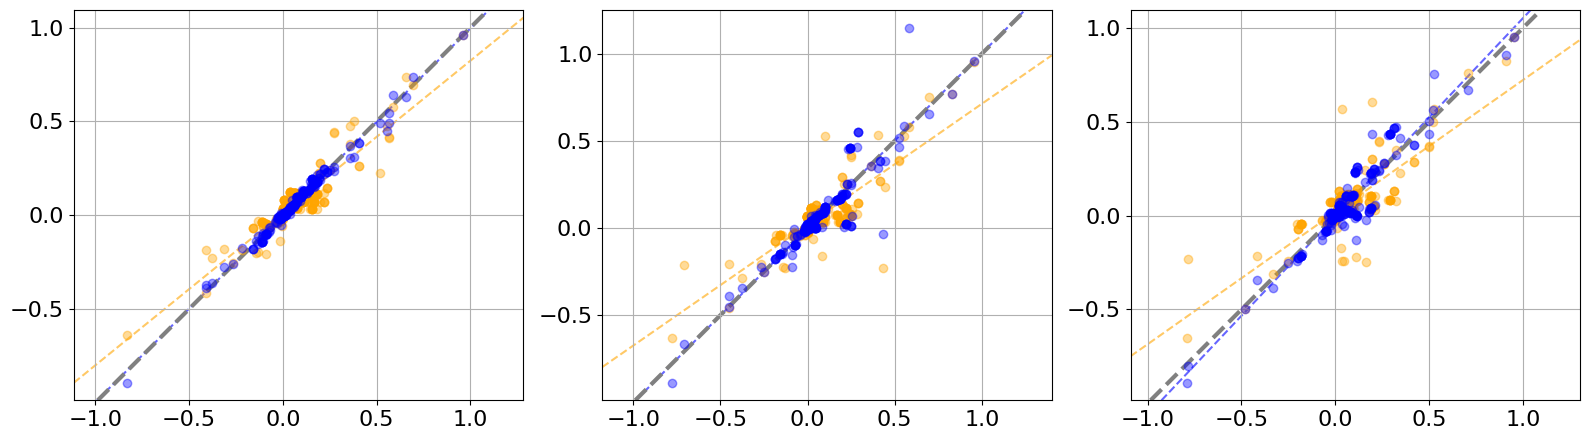

In [80]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(1, 3, figsize=(16,4.5))


for ii in range(3):
    ax[ii].tick_params(axis='both', which='major', labelsize=16)

"""
priorFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2
"""

ax[0].set_aspect('equal', 'datalim')
ax[0].scatter(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0].scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].grid()

ax[1].set_aspect('equal', 'datalim')
ax[1].scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1].scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].grid()

ax[2].set_aspect('equal', 'datalim')
ax[2].scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[2].scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].grid()
    
f.tight_layout()
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-combinedFCCs.svg', format="svg")

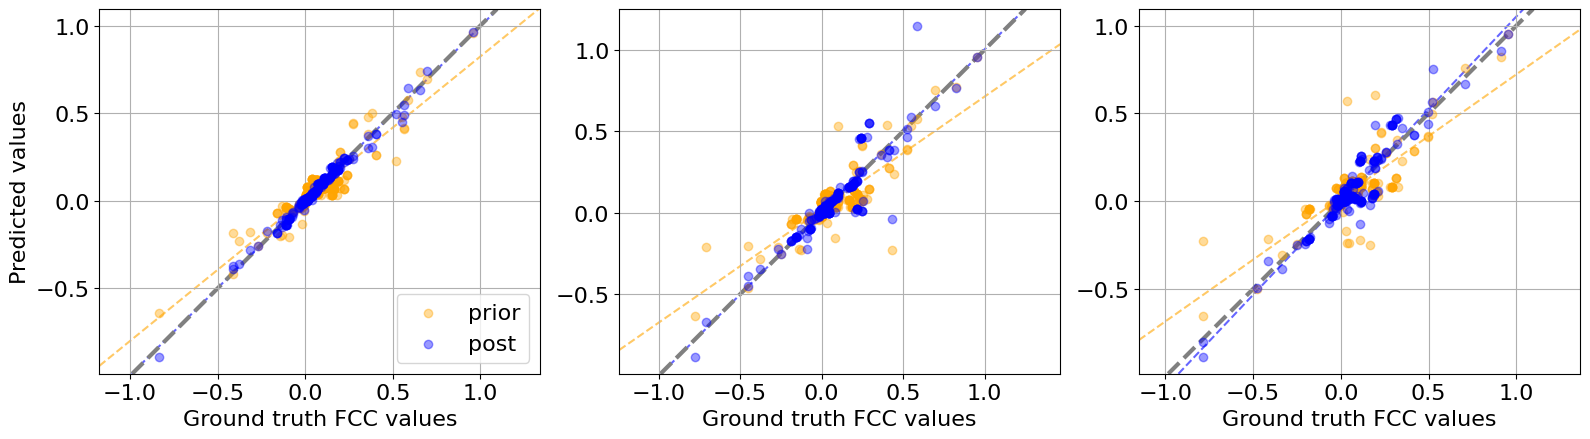

In [63]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(1, 3, figsize=(16,4.5))

for ii in range(3):
    ax[ii].tick_params(axis='both', which='major', labelsize=16)

ax[0].set_aspect('equal', 'datalim')
ax[0].scatter(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0].scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].grid()
ax[0].legend(loc="lower right", fontsize=16)
ax[0].set_xlabel('Ground truth FCC values', fontsize=16)

ax[1].set_aspect('equal', 'datalim')
ax[1].scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1].scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].grid()
ax[1].set_xlabel('Ground truth FCC values', fontsize=16)

ax[2].set_aspect('equal', 'datalim')
ax[2].scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[2].scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].grid()

ax[2].set_xlabel('Ground truth FCC values', fontsize=16)
ax[0].set_ylabel('Predicted values', fontsize=16)

f.tight_layout()

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-combinedFCCs.svg', format="svg")

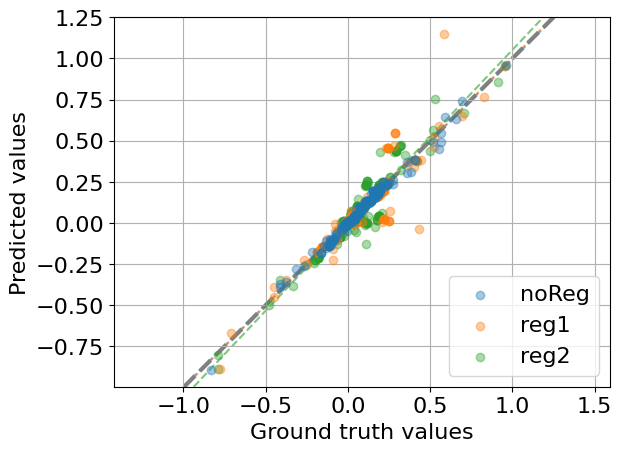

In [64]:
# Create two subplots and unpack the output array immediately

plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='noReg', zorder=300)
plt.scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='reg1', zorder=200)
plt.scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('Ground truth values', fontsize=16)
plt.ylabel('Predicted values', fontsize=16)

_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

f.tight_layout()

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-combinedFCCs_byAllostery.svg', format="svg")

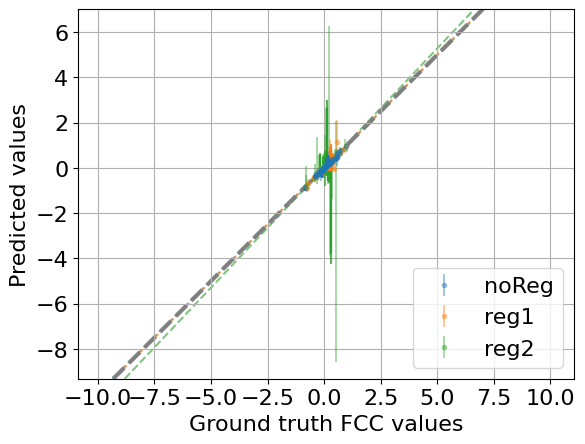

In [65]:
# fruit

plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', markersize=3, label='noReg', zorder=300)
plt.errorbar(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], yerr=FCC_errors_reg1_post, alpha=0.4, fmt='o', markersize=3, label='reg1', zorder=200)
plt.errorbar(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], yerr=FCC_errors_reg2_post, alpha=0.4, fmt='o', markersize=3, label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('Ground truth FCC values', fontsize=16)
plt.ylabel('Predicted values', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#f.tight_layout()

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/FCCs/top{topology}-{omission}-combinedFCCs_byAllostery_wError.svg', format="svg")

## Quantifying the number of FCCs in top ten that were Predicted correctly by BMCA


In [66]:
rank_counts_df = pd.read_csv('../data/results/TopologyA_top10.csv')

In [67]:
rank_counts_df.head()

,Perturbation,omittedData,regulation,count,type
0,0.1x,allData,noReg,7,prior
1,0.2x,allData,noReg,7,prior
2,0.3x,allData,noReg,7,prior
3,0.4x,allData,noReg,7,prior
4,0.5x,allData,noReg,7,prior


In [68]:
stagbar_counts = rank_counts_df.pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])
stagbar_counts

C:\Users\user\AppData\Local\Temp\ipykernel_54900\1542227218.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\1542227218.py:1: FutureWarning:

The operation <function std at 0x000001DD9C0AA160> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.



,omittedData,type,mean,std
,,,count,count
1,allData,prior,6.700000,0.466092
0,allData,post,8.233333,1.278019
7,omitFluxes,prior,6.666667,0.479463
6,omitFluxes,post,7.066667,0.784915
3,omitEnzymes,prior,6.666667,0.479463
2,omitEnzymes,post,7.433333,0.858360
9,omitIntMet,prior,6.666667,0.479463
8,omitIntMet,post,8.066667,1.172481
5,omitExMet,prior,6.700000,0.466092


C:\Users\user\AppData\Local\Temp\ipykernel_54900\3776606208.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



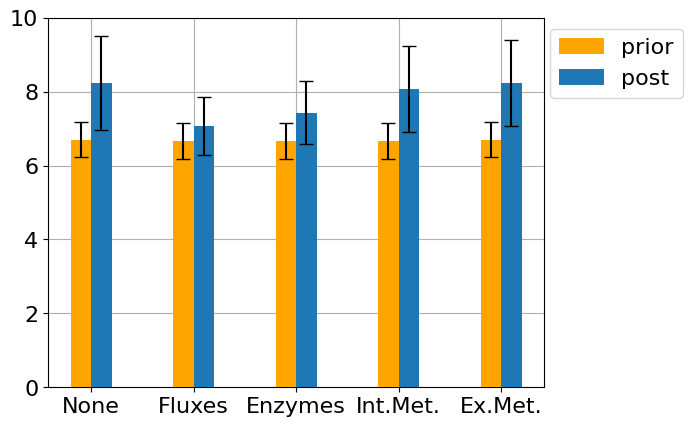

In [69]:
ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int.Met.', 'Ex.Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend(fontsize=16, bbox_to_anchor=(0.99, 1))
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.savefig(f'../visualize/raw_svg_figures/top{topology}/top{topology}_rankCounts.svg', format='svg')

C:\Users\user\AppData\Local\Temp\ipykernel_54900\2165574196.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\2165574196.py:1: FutureWarning:

The operation <function std at 0x000001DD9C0AA160> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\2165574196.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



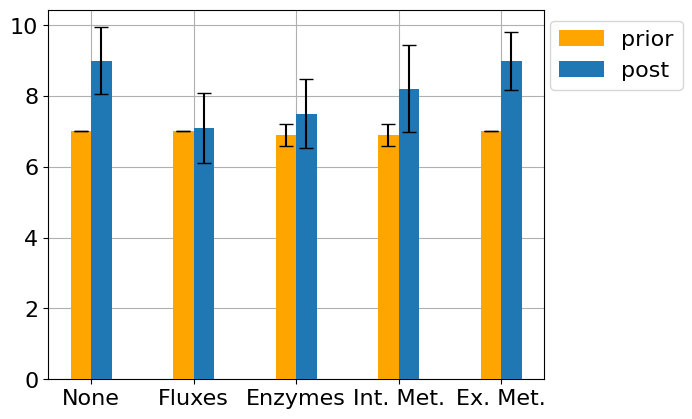

In [70]:
stagbar_counts = rank_counts_df[rank_counts_df['regulation']=='noReg'].pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])

ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int. Met.', 'Ex. Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend(bbox_to_anchor=(0.99, 1),fontsize=16)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.savefig(f'../visualize/raw_svg_figures/top{topology}/top{topology}-noReg_rankCounts.svg', format='svg')

C:\Users\user\AppData\Local\Temp\ipykernel_54900\3049835658.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\3049835658.py:1: FutureWarning:

The operation <function std at 0x000001DD9C0AA160> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\3049835658.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



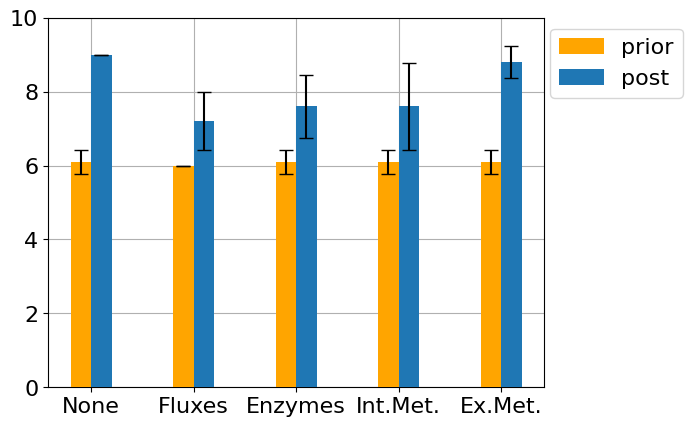

In [71]:
stagbar_counts = rank_counts_df[rank_counts_df['regulation']=='reg1'].pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])

ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int.Met.', 'Ex.Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend(bbox_to_anchor=(0.99, 1),fontsize=16)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/top{topology}-reg1_rankCounts.svg', format='svg')

C:\Users\user\AppData\Local\Temp\ipykernel_54900\2637775999.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\2637775999.py:1: FutureWarning:

The operation <function std at 0x000001DD9C0AA160> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.

C:\Users\user\AppData\Local\Temp\ipykernel_54900\2637775999.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



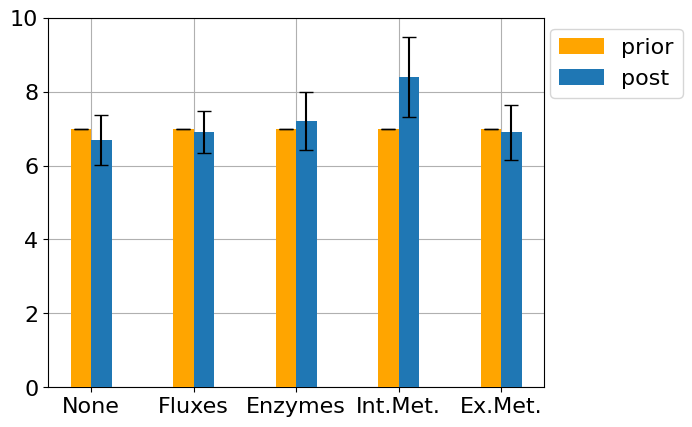

In [72]:
stagbar_counts = rank_counts_df[rank_counts_df['regulation']=='reg2'].pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])

ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int.Met.', 'Ex.Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend(bbox_to_anchor=(0.99, 1),fontsize=16)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)

plt.savefig(f'../visualize/raw_svg_figures/top{topology}/top{topology}-reg2_rankCounts.svg', format='svg')

## Visualizing Spearman data 

### Condensing all the spearman r data

In [73]:
os.chdir(f'../data/results/spearman_coefficients/topology{topology}/')

In [74]:
spr_file_list = [i for i in os.listdir()]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('-')[1].split('_')[0]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_A = pd.concat(spr_dfs)
all_spr_df_A

,Unnamed: 0,r,p-value,lower,upper,reg,omit
0,0.1x-prior,0.260714,0.347979,-0.393355,0.768542,noReg,allData
1,0.2x-prior,0.300000,0.277317,-0.306928,0.801227,noReg,allData
2,0.3x-prior,0.292857,0.289472,-0.336062,0.791288,noReg,allData
3,0.4x-prior,0.242857,0.383128,-0.451922,0.780877,noReg,allData
4,0.5x-prior,0.253571,0.361816,-0.454595,0.820913,noReg,allData
...,...,...,...,...,...,...,...
15,1.5x-post,0.757143,0.001081,0.320935,0.956600,reg2,omitIntMet
16,3x-post,0.675000,0.005763,0.143207,0.882022,reg2,omitIntMet
17,5x-post,0.725000,0.002227,0.323503,0.919572,reg2,omitIntMet
18,7x-post,0.489286,0.064160,0.008997,0.821596,reg2,omitIntMet


In [75]:
os.chdir('../../../../notebooks/')

In [76]:
all_spr_df_A.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_A['distr'] = [(i.split('-')[1]) for i in all_spr_df_A['perturbation']]
all_spr_df_A['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_A['perturbation']]


In [77]:
all_spr_df_A = all_spr_df_A[all_spr_df_A['perturbation'] != 1.01]
all_spr_df_A

,perturbation,r,p-value,lower,upper,reg,omit,distr
0,0.1,0.260714,0.347979,-0.393355,0.768542,noReg,allData,prior
1,0.2,0.300000,0.277317,-0.306928,0.801227,noReg,allData,prior
2,0.3,0.292857,0.289472,-0.336062,0.791288,noReg,allData,prior
3,0.4,0.242857,0.383128,-0.451922,0.780877,noReg,allData,prior
4,0.5,0.253571,0.361816,-0.454595,0.820913,noReg,allData,prior
...,...,...,...,...,...,...,...,...
15,1.5,0.757143,0.001081,0.320935,0.956600,reg2,omitIntMet,post
16,3.0,0.675000,0.005763,0.143207,0.882022,reg2,omitIntMet,post
17,5.0,0.725000,0.002227,0.323503,0.919572,reg2,omitIntMet,post
18,7.0,0.489286,0.064160,0.008997,0.821596,reg2,omitIntMet,post


In [78]:
a = pd.pivot_table(all_spr_df_A, values=['r'], index=['omit', 'distr'], aggfunc=['mean', 'std'], sort=False)
a.reset_index(inplace=True)
a = a.reindex([0,1,6,7,2,3,8,9,4,5])
a

,omit,distr,mean,std
,,,r,r
0,allData,prior,0.201071,0.115172
1,allData,post,0.754048,0.151264
6,omitFluxes,prior,0.177143,0.096611
7,omitFluxes,post,0.207738,0.202381
2,omitEnzymes,prior,0.202500,0.091508
3,omitEnzymes,post,0.417500,0.246146
8,omitIntMet,prior,0.197262,0.092114
9,omitIntMet,post,0.462500,0.361262
4,omitExMet,prior,0.214048,0.101428


### Graph of aggregated Spearman corr

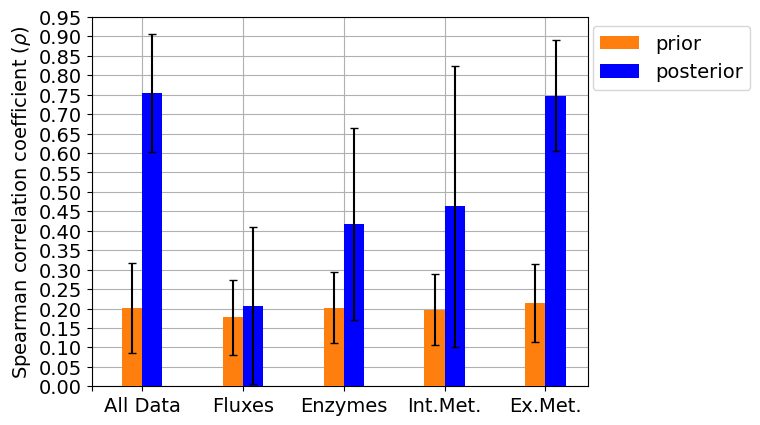

In [79]:
# plot
ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], a[a['distr']=='prior']['mean'].squeeze(), width=0.2, color='tab:orange', align='center', zorder=100, label='prior')
ax.bar([i+0.1 for i in range(5)], a[a['distr']=='post']['mean'].squeeze(), width=0.2, color='blue', align='center', zorder=100, label='posterior')

## add error bars
plt.errorbar([i-0.1 for i in range(5)], a[a['distr']=='prior']['mean'].squeeze(), 
             yerr=a[a['distr']=='prior']['std'].squeeze(), 
             color='black', capsize=3, zorder=1000, ls='none')

plt.errorbar([i+0.1 for i in range(5)], a[a['distr']=='post']['mean'].squeeze(), 
             yerr=a[a['distr']=='post']['std'].squeeze(), 
             color='black', capsize=3, zorder=1000, ls='none')

ax.set_xticks([-0.5]+list(np.arange(0,5)))
_ = ax.set_xticklabels(['', 'All Data', "Fluxes", 'Enzymes', "Int.Met.", "Ex.Met."], size=14) ## fix the labels
_ = ax.set_yticks(np.arange(0,1,0.05))

ax.legend()

plt.ylabel(r'Spearman correlation coefficient ($\rho$)', size=14)

ax.legend(bbox_to_anchor=(0.99, 1),fontsize=14)
_=plt.xticks(fontsize=14)
_=plt.yticks(fontsize=14)


plt.savefig(f'../visualize/raw_svg_figures/top{topology}/Top{topology}_sprCorr.svg', format='svg' )